In [1]:
import os
from osgeo import gdal
import richdem as rd
from osgeo import ogr

import numpy as np
import rasterio
import rasterstats
import matplotlib
import geopandas as gpd
import fiona

import richdem as rd
import rioxarray as rxr
import matplotlib.pyplot as plt

from rasterstats import zonal_stats
from rasterio.plot import show_hist
from shapely.ops import cascaded_union
from shapely.geometry import shape
from shapely.geometry import box

#For advanced "print" options (printmd)
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    



In [2]:
import sys
print(sys.path)

['C:\\Users\\julia\\Downloads\\softwareDev_finProject-main(2)\\softwareDev_finProject-main', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\python310.zip', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\DLLs', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\lib', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1', '', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\lib\\site-packages', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\lib\\site-packages\\win32', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\lib\\site-packages\\win32\\lib', 'C:\\Users\\julia\\anaconda3\\envs\\finalproject1\\lib\\site-packages\\Pythonwin']


In [3]:
## reproject crs from testdata
input_raster = gdal.Open('testdata.tif')
output_raster = './results/testdata_EPSG25832.tif'
warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:25832')

testdata = rd.LoadGDAL("./results/testdata_EPSG25832.tif", no_data=-9999)

## calculate slope, aspect, curvature
slope = rd.TerrainAttribute(testdata, attrib='slope_degrees', zscale=1)
aspect = rd.TerrainAttribute(testdata, attrib='aspect', zscale=1.0)
# curvature = rd.TerrainAttribute(testdata, attrib='curvature', zscale=1)
# planform_curvature = rd.TerrainAttribute(testdata, attrib='planform_curvature', zscale=1)
profile_curvature = rd.TerrainAttribute(testdata, attrib='profile_curvature', zscale=1)

## show results
# rd.rdShow(slope, axes=False, cmap='gray', figsize=(8,5.5))
# rd.rdShow(aspect, axes=False, cmap='gray', figsize=(8,5.5))
# rd.rdShow(curvature, axes=False, cmap='gray', figsize=(8,5.5))
# rd.rdShow(planform_curvature, axes=False, cmap='gray', figsize=(8,5.5))
# rd.rdShow(profile_curvature, axes=False, cmap='gray', figsize=(8,5.5))

## save results as tif
rd.SaveGDAL("./results/slope.tif", slope)
rd.SaveGDAL("./results/aspect.tif", aspect)
# rd.SaveGDAL("./results/curvature.tif", curvature)
# rd.SaveGDAL("./results/planform_curvature.tif", planform_curvature)
rd.SaveGDAL("./results/profile_curvature.tif", profile_curvature)



In [ ]:
## calculate slope with angles ranging from 28 to 54 degrees
cmd = 'gdal_calc.py --calc="A*logical_and(A>=28,A<=54)" --outfile=./results/slope_relevant.tif -A ./results/slope.tif --NoDataValue=0'
os.system(cmd)

# slope_relevant =  rd.LoadGDAL("slope_relevant.tif", no_data=-9999)
# rd.rdShow(slope_relevant, axes=False, cmap='gray', figsize=(8,5.5))

## colorize relevant slope
cmd1 = 'gdaldem color-relief ./results/slope_relevant.tif color_slope_gradient.txt ./results/slope_relevant_color.tif -nearest_color_entry -alpha'
os.system(cmd1)

## generate hillshade
cmd2 = 'gdaldem hillshade ./results/testdata_EPSG25832.tif ./results/hillshade.tif'
os.system(cmd2)

## colorize aspect in cardinal directions N=green, E=red, S=violett, W=yellow
cmd3 = 'gdaldem color-relief ./results/aspect.tif color_aspect_cardinal_directions.txt ./results/aspect_color.tif -nearest_color_entry'
os.system(cmd3)

## calculate profile curvature >0
cmd4 = 'gdal_calc.py --calc="A*(A<0)" --outfile=./results/profile_curvature_relevant.tif -A ./results/profile_curvature.tif --NoDataValue=0'
os.system(cmd4)

## combine profile_curvature_color with hillshade
cmd5 = 'gdal_merge.py -separate -n -9999 -o ./results/new_rgb.tif ./results/profile_curvature_relevant.tif ./results/hillshade.tif'
os.system(cmd5)

In [ ]:
src = gdal.Open('./results/slope_relevant_color.tif')
addlBand = gdal.Open('./results/hillshade.tif')
newBand = addlBand.GetRasterBand(1).ReadAsArray()

tmp = gdal.GetDriverByName('MEM').CreateCopy('', src, 0)
# tmp.AddBand()
tmp.GetRasterBand(4).WriteArray(newBand)

dst = gdal.GetDriverByName('GTiff').CreateCopy('./results/combined_profCurv_hillsh.tif', tmp, 0)
del dst

In [ ]:
## create vector polygons from relevant area
cmd6 = 'gdal_polygonize.py ./results/slope_relevant.tif -b 1 ./results/slope_relevant.shp slope area'
os.system(cmd6)

## calculate area
cmd7 = 'ogrinfo -sql "SELECT SUM(OGR_GEOM_AREA) AS TOTAL_AREA FROM slope_relevant" ./results/slope_relevant.shp'
os.system(cmd7)

os.popen('ogrinfo -sql "SELECT SUM(OGR_GEOM_AREA) AS TOTAL_AREA FROM slope_relevant" ./results/slope_relevant.shp').read()

In [4]:
# Define the Path of the Slope tif for Slope analysis

slope_analysis = "./results/slope.tif"


In [5]:
dataset_slope = rasterio.open(slope_analysis)
print(dataset_slope)

<open DatasetReader name='./results/slope.tif' mode='r'>


In [6]:
# Define the Path of the DEM for DEM analysis

dem_analysis = "testdata.tif"

In [7]:
dataset_dem = rasterio.open(dem_analysis)
print(dataset_dem)

<open DatasetReader name='testdata.tif' mode='r'>


In [8]:
#Show propoerties of selected Raster
img_name = dataset_slope.name
printmd("**Properties of the Image with the filename:** {n}\n".format(n=img_name))

num_bands = dataset_slope.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

rows, cols = dataset_slope.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

desc = dataset_slope.descriptions
metadata = dataset_slope.meta

print('Raster description: {desc}\n'.format(desc=desc))

driver = dataset_slope.driver
print('Raster driver: {d}\n'.format(d=driver))

proj = dataset_slope.crs
print('Image projection:')
print(proj, '\n')

gt = dataset_slope.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

**Properties of the Image with the filename:** ./results/slope.tif


Number of bands in image: 1

Image size is: 1527 rows x 1980 columns

Raster description: (None,)

Raster driver: GTiff

Image projection:
EPSG:25832 

Image geo-transform:
| 69.95, 0.00, 743185.09|
| 0.00,-69.95, 5328879.31|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1980, 'height': 1527, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(69.94775638389548, 0.0, 743185.090039658,
       0.0, -69.94775638389548, 5328879.312031286)}




In [9]:
#Show propoerties of selected Raster

img_name = dataset_dem.name
printmd("**Properties of the Image with the filename:** {n}\n".format(n=img_name))

num_bands = dataset_dem.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

rows, cols = dataset_dem.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

desc = dataset_dem.descriptions
metadata = dataset_slope.meta

print('Raster description: {desc}\n'.format(desc=desc))

driver = dataset_dem.driver
print('Raster driver: {d}\n'.format(d=driver))

proj = dataset_dem.crs
print('Image projection:')
print(proj, '\n')

gt = dataset_dem.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

**Properties of the Image with the filename:** testdata.tif


Number of bands in image: 1

Image size is: 1077 rows x 2124 columns

Raster description: (None,)

Raster driver: GTiff

Image projection:
EPSG:4326 

Image geo-transform:
| 0.00, 0.00, 12.26|
| 0.00,-0.00, 48.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1980, 'height': 1527, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(69.94775638389548, 0.0, 743185.090039658,
       0.0, -69.94775638389548, 5328879.312031286)}




In [10]:
#Input for the Raster Statistics
nir = dataset_slope.read(1)

#Generate Statistics
band_mean = np.mean(nir) 
band_min = np.amin(nir)
band_max = np.amax(nir)
band_stddev = np.std(nir)

printmd ('**Statistics of Slope Raster:**')
print('range of selected Band: {minimum} - {maximum}'.format(maximum=band_max,
                                                 minimum=band_min))
print('mean of selected Band: {m}'.format(m=band_mean))
print('stdev of selected Band: {s}'.format(s=band_stddev))

**Statistics of Slope Raster:**

range of selected Band: 0.0 - 87.86485290527344
mean of selected Band: 17.17755889892578
stdev of selected Band: 14.374165534973145


In [11]:
# Input for the Raster Statistics
nir1 = dataset_dem.read(1)

# Generate Statistics
band_mean = np.mean(nir1) 
band_min = np.amin(nir1)
band_max = np.amax(nir1)
band_stddev = np.std(nir1)

printmd ('**Statistics of DEM Raster:**')
print('range of selected Band: {minimum} - {maximum}'.format(maximum=band_max,
                                                 minimum=band_min))
print('mean of selected Band: {m}'.format(m=band_mean))
print('stdev of selected Band: {s}'.format(s=band_stddev))


**Statistics of DEM Raster:**

range of selected Band: 372 - 3627
mean of selected Band: 1171.8489365031903
stdev of selected Band: 555.4342813725074


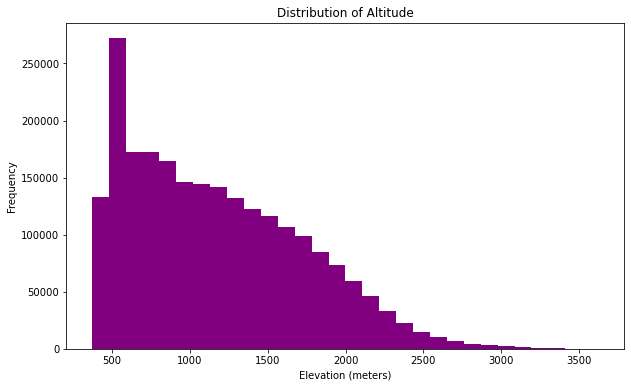

In [12]:
# Define the input for the histogram
dem_im = rxr.open_rasterio(dem_analysis, masked=True)

# Plot the histogram
f, ax = plt.subplots(figsize=(10, 6))
dem_im.plot.hist(ax=ax,
                       color="purple",
                       bins=30)
ax.set(title="Distribution of Altitude",
       xlabel='Elevation (meters)',
       ylabel='Frequency')
plt.show()

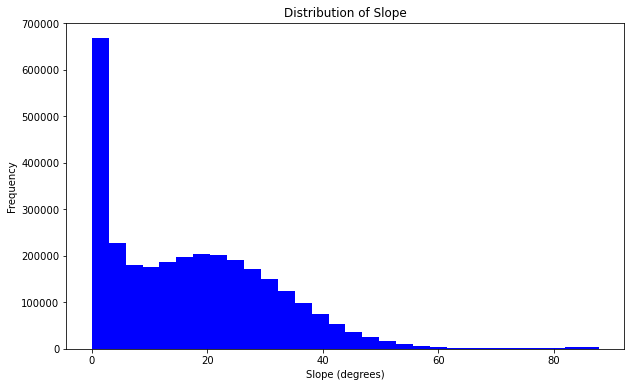

In [13]:
# Define the input for the histogram
slope_im = rxr.open_rasterio(slope_analysis, masked=True)

# Plot the histogram
f, ax = plt.subplots(figsize=(10, 6))
slope_im.plot.hist(ax=ax,
                       color="blue",
                       bins=30)
ax.set(title="Distribution of Slope",
       xlabel='Slope (degrees)',
       ylabel='Frequency')
plt.show()

**Checking the selected Polygons for Zonal Statistic:**

   Shape_Leng  Shape_Area            Type  \
0    0.995679    0.024233          Forest   
1    0.000000    0.000000  Populated Area   

                                            geometry  
0  POLYGON Z ((12.80574 47.63102 0.00000, 12.8212...  
1  POLYGON Z ((13.16349 47.60323 0.00000, 13.1674...  


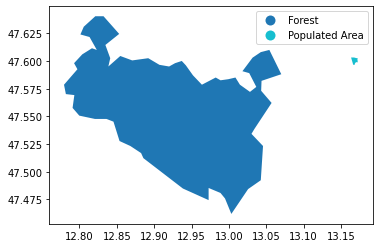

In [14]:
#ZONAL STATISTICS 1: ZONAL STATISTICS FOR DEFINED STUDY AREAS / AREAZONAL.SHP

# Before calculating the zonal statistics, checking if the slected polygons (zones) are valid. 

printmd ('**Checking the selected Polygons for Zonal Statistic:**')

gdf = gpd.read_file('areazonal.shp')

%matplotlib inline
gdf.plot(column='Type', cmap=None, legend=True)

print (gdf)

In [15]:
#calculate the actual zonal statistics (elevation in the study area)
# once seperate for the two study ares

printmd("**Zonal statistics, seperate for the two study areas in the raster with the filename:** {n}\n".format(n=img_name))

stats1=zonal_stats("areazonal.shp", "testdata.tif", nodata=np.nan,
            stats="count min mean max median nodata range")



**Zonal statistics for the study area in the raster with the filename:** testdata.tif


[{'min': 593.0,
  'max': 2668.0,
  'mean': 1530.4450845514475,
  'count': 34890,
  'median': 1576.0,
  'range': 2075.0,
  'nodata': 0.0},
 {'min': 465.0,
  'max': 495.0,
  'mean': 474.74545454545455,
  'count': 55,
  'median': 475.0,
  'range': 30.0,
  'nodata': 0.0}]

In [21]:
#... and once for both areas combined

# use the GeoSeries.unary_union Function of Geopanda to show the union of all geometries in the GeoSeries
src1 = fiona.open('areazonal.shp')
geoms1 = [shape(feature['geometry']) for feature in src1]

m1 = gpd.GeoSeries(geoms1)

union1 = m1.unary_union

printmd("**Zonal statistics for both study areas combined:**")
zonal_stats([union1], "testdata.tif", nodata=np.nan,
            stats="count min mean max median nodata range")

**Zonal statistics for both study areas combined:**

[{'min': 465.0,
  'max': 2668.0,
  'mean': 1528.7835169552154,
  'count': 34945,
  'median': 1575.0,
  'range': 2203.0,
  'nodata': 0.0}]

In [ ]:
#ZONAL STATISTICS 2: ZONAL STATISTICS FOR THE RESULTS/SLOPE_RELEVANT.SHP
# Before calculating the zonal statistics, checking if the slected polygons (zones) are valid. 

printmd ('**Checking the selected Area for Zonal Statistic:**')

gdf = gpd.read_file('results/slope_relevant.shp')

%matplotlib inline
gdf.plot(column='area', cmap=None, legend=True)

print (gdf)

In [ ]:
# use the GeoSeries.unary_union Function of Geopanda to show the union of all geometries in the GeoSeries

src = fiona.open('results/slope_relevant.shp')
geoms = [shape(feature['geometry']) for feature in src]

m = gpd.GeoSeries(geoms)

union = m.unary_union

In [ ]:
#calculate the actual zonal statistics

printmd("**Zonal statistics for the area with relevant slope values in the raster with the filename:** {n}\n".format(n=img_name))
zonal_stats([union], "testdata.tif", nodata=np.nan,
            stats="count min mean max median nodata range")